In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OrdinalEncoder as OE
from sklearn.preprocessing import LabelEncoder as LE
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from xgboost import plot_importance

In [3]:
d = "C:\kaggle_data\credit_card"

In [4]:
lst = os.listdir(d)
print(lst)

['sample_submission.csv', 'test.csv', 'train.csv']


In [5]:
train = pd.read_csv(d + '\\' +lst[2])
test = pd.read_csv(d + '\\' +lst[1])
ss = pd.read_csv(d + '\\' +lst[0])

In [6]:
total = pd.concat([train, test])
train = train.drop('FLAG_MOBIL',1)
test = test.drop('FLAG_MOBIL',1)

# 개요
## target 변수
- credit: 타겟변수, 
    [0, 1, 2]

## 설명 변수
- gender: 성별 [M, F]
- car : 차량 소유 여부 [Y, N]
- reality: 부동산 소유 여부 [Y, N]
- FLAG_MOBIL: 핸드폰 소유 여부, T/F, [1]
- work_phone: 업무용 전화 소유 여부, T/F, [0,1]
- phone : 전화 소유 여부, T/F, [0,1]
- email : 이메일 소유 여부, T/F, [0,1]  
    
    
    
- child_num: 자녀 수, int
    [인트형]
    
- family_size: 가족 규모, int,

- income_total : 연간 소득, int


- DAYS_BIRTH : 출생일, 데이터 수집일이 0이고 역으로 계산, int
- DAYS_EMPLOYED: 업무 시작일, 데이터 수집일이 0이고 역으로 계산, int
- begin_month : 신용카드 발급 월, 수집 당시 0 역으로 계산,int형


- occyp_type : 직업 유형, categorical,  [nan, 'Laborers', 'Managers', 'Sales staff', 'High skill tech staff', 'Core staff', 'Drivers', 'Medicine staff','Accountants', 'Realty agents', 'Security staff', 'Cleaning staff','Private service staff', 'Cooking staff', 'Secretaries','HR staff', 'IT staff', 'Low-skill Laborers','Waiters/barmen staff']
- income_type : 소득 분류, categorical
    ['Commercial associate', 'Working', 'State servant', 'Pensioner', 'Student']
- edu_type : 교육 수준, , categorical
    ['Higher education' ,'Secondary / secondary special', 'Incomplete higher', 'Lower secondary', 'Academic degree']
- family_type : 결혼 여부, categorical
    ['Married', 'Civil marriage', 'Separated', 'Single / not married', 'Widow']
- house_type: 생활 방식, categorical
    ['Municipal apartment', 'House / apartment', 'With parents', 'Co-op apartment', 'Rented apartment', 'Office apartment']

## days_employed는 -면 취직상태
## occyp_type

In [15]:
nan = train['occyp_type'].values[0]

In [18]:
train['occyp_type'] = train['occyp_type'].fillna('missing')

<AxesSubplot:xlabel='credit', ylabel='count'>

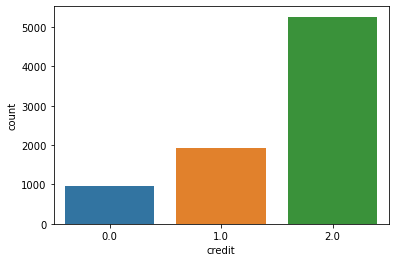

In [22]:
sns.countplot(train.loc[train['occyp_type']=='missing','credit'])

In [30]:
temp = train.loc[train['occyp_type']=='missing','credit']
t = temp.value_counts().sum()

In [31]:
temp.value_counts().values/t

array([0.64447436, 0.23718027, 0.11834537])

In [33]:
t = train['credit'].value_counts().sum()
train['credit'].value_counts().values/t

array([0.64134256, 0.23687493, 0.12178252])

In [41]:
ts = train.loc[train['occyp_type']=='missing','DAYS_EMPLOYED']
print(ts.min(), ts.max())

-15072 365243


In [47]:
# 무직 백수든 아니든 credit의 분포가 비슷하다
temp = train.loc[train['DAYS_EMPLOYED']==365243,'credit']
print(temp.value_counts().values/temp.value_counts().sum())
temp = train.loc[train['DAYS_EMPLOYED']!=365243,'credit']
print(temp.value_counts().values/temp.value_counts().sum())

[0.63497071 0.24425417 0.12077512]
[0.64262682 0.23538762 0.12198556]


In [52]:
# missing이고 365243인 사람은?
temp_1 = train.loc[(train['DAYS_EMPLOYED']==365243)&(train['occyp_type']=='missing'),'credit']
temp_2 = train.loc[(train['DAYS_EMPLOYED']!=365243)&(train['occyp_type']=='missing'),'credit']

In [54]:
# 오 그래도 여태 해본 것 중 제일 낫다 ㅋ
print(temp_1.value_counts().values/temp_1.value_counts().sum())
print(temp_2.value_counts().values/temp_2.value_counts().sum())

[0.63497071 0.24425417 0.12077512]
[0.65577284 0.22877043 0.11545674]


<AxesSubplot:xlabel='DAYS_EMPLOYED', ylabel='Density'>

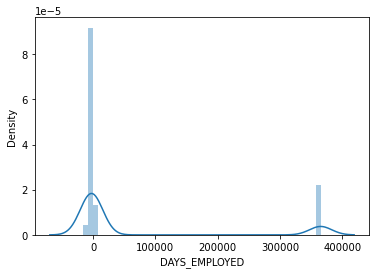

In [57]:
sns.distplot(train['DAYS_EMPLOYED'])

In [67]:
train.loc[train['DAYS_EMPLOYED']==365243,'DAYS_EMPLOYED'] = 1

In [63]:
train.loc[train['DAYS_EMPLOYED']>=0,'DAYS_EMPLOYED'].value_counts()

100    4438
Name: DAYS_EMPLOYED, dtype: int64

<AxesSubplot:xlabel='DAYS_EMPLOYED', ylabel='Density'>

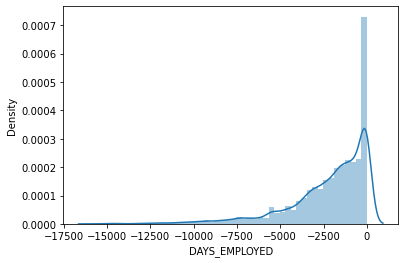

In [68]:
sns.distplot(train['DAYS_EMPLOYED'])

<AxesSubplot:xlabel='credit', ylabel='DAYS_EMPLOYED'>

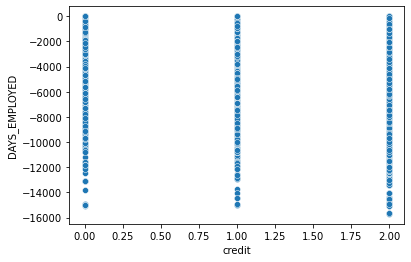

In [72]:
sns.scatterplot(y=train['DAYS_EMPLOYED'],x=train['credit'])

In [74]:
train['YEARS_EMPLOYED'] = train['DAYS_EMPLOYED']/365
train['WEEKS_EMPLOYED'] = train['DAYS_EMPLOYED']/7

<AxesSubplot:xlabel='YEARS_EMPLOYED', ylabel='Count'>

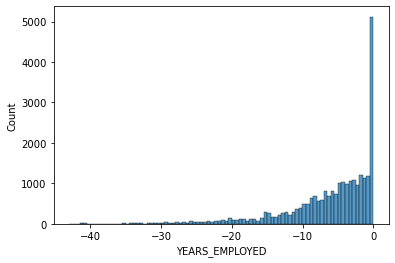

In [80]:
sns.scatterplot(y=train['YEARS_EMPLOYED'].round(),x=train['credit'])

In [82]:
train['YEARS_EMPLOYED'] = train['YEARS_EMPLOYED'].round()

<AxesSubplot:xlabel='YEARS_EMPLOYED', ylabel='credit'>

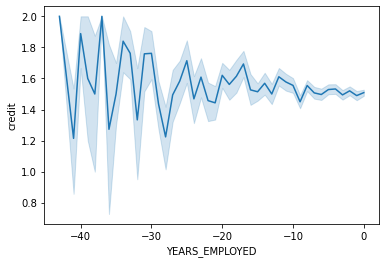

In [85]:
sns.lineplot(x='YEARS_EMPLOYED',y='credit',data=train)

# 정리
- 같은 no_job이어도 백수인 사람과 아닌 사람은 차이가 있었다
- 각 직업별 income_total 확인해보기
- 수익의 비율(자산수익, 월급수익)
- 각 직업별로 5년마다 구간 나눠서 평균 비교해보기

In [88]:
(train['income_total']<=0).sum()

0

In [89]:
train['log_income'] = np.log(train['income_total'])

<AxesSubplot:xlabel='occyp_type', ylabel='log_income'>

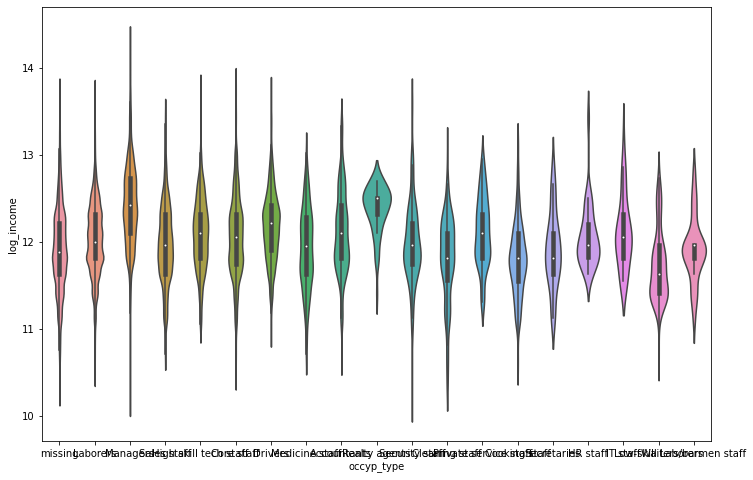

In [98]:
fig= plt.figure(figsize=(12,8))
fig.gca()
sns.violinplot(x='occyp_type',y='log_income',data=train)

<AxesSubplot:xlabel='occyp_type', ylabel='log_income'>

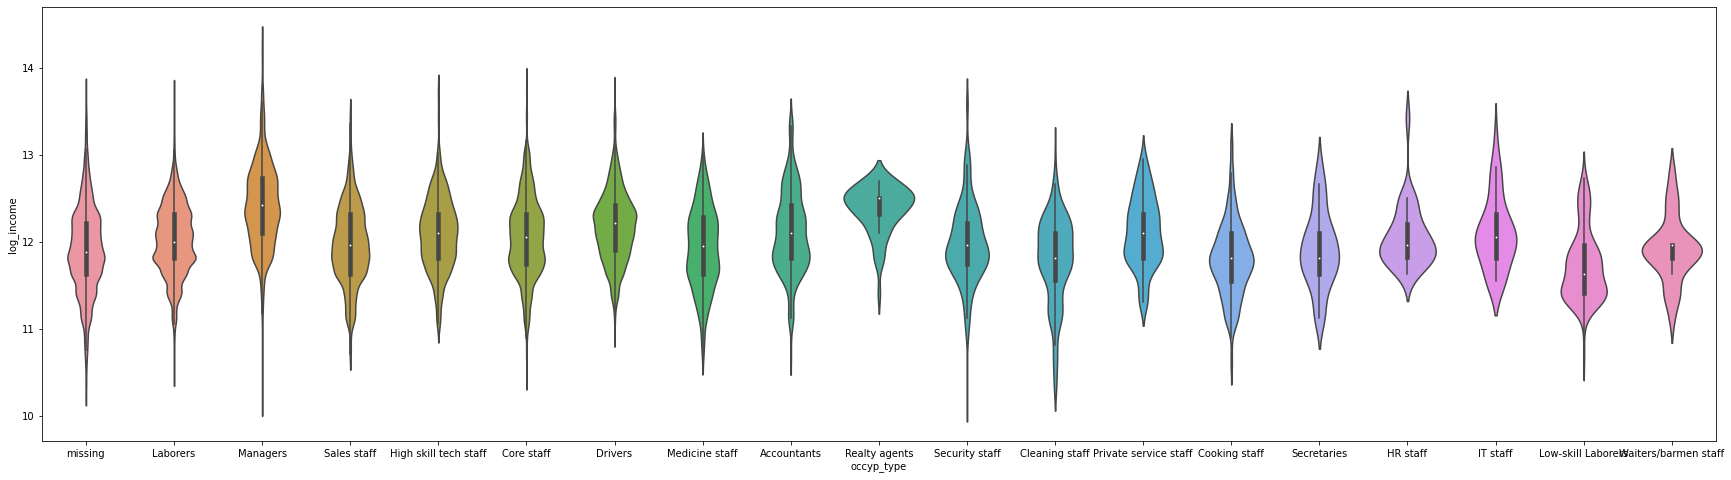

In [97]:
fig= plt.figure(figsize=(30,8))
fig.gca()
sns.violinplot(x='occyp_type',y='log_income',data=train)

In [ ]:
# 직업 drop

<AxesSubplot:xlabel='occyp_type', ylabel='log_income'>

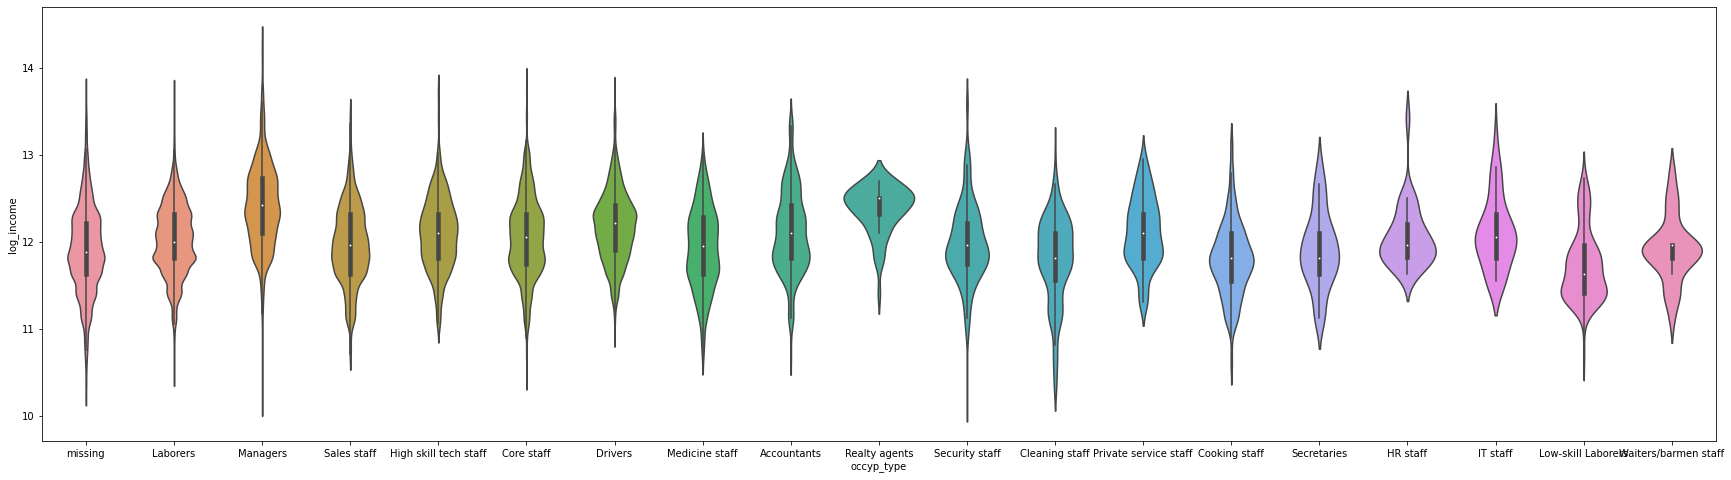

In [100]:
fig= plt.figure(figsize=(30,8))
fig.gca()
sns.violinplot(x='occyp_type',y='log_income',data=train)
# 의미있는 직업 구분
# Reality agents, service staff, secretaries, HR staff, waiter/barmen

In [ ]:
# security, cleaning, accountants, core staff, managers, laborers, sales, high skill
# 위 직업별로 왜 차이가 

In [103]:
train['liab'] = 0
train.loc[(train.car=='Y')&(train.reality=='Y'),'liab']=1

<AxesSubplot:xlabel='credit', ylabel='log_income'>

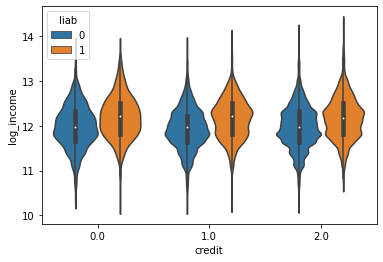

In [104]:
sns.violinplot(x='credit',y='log_income',data=train,hue='liab')

In [111]:
train.loc[(train['DAYS_EMPLOYED']>=0)&(train['occyp_type']=='missing'),'occyp_type']='BS'

In [114]:
train['occyp_type'].unique()

array(['missing', 'Laborers', 'Managers', 'Sales staff',
       'High skill tech staff', 'Core staff', 'Drivers', 'Medicine staff',
       'Accountants', 'BS', 'Realty agents', 'Security staff',
       'Cleaning staff', 'Private service staff', 'Cooking staff',
       'Secretaries', 'HR staff', 'IT staff', 'Low-skill Laborers',
       'Waiters/barmen staff'], dtype=object)

In [123]:
# 각 직업별 평균 수익과 상위 99 하위 99 출력
_99 = []
_1 = []
_mean = []
for job in train['occyp_type'].unique():
    temp = train[train['occyp_type']==job]
    temp = temp['log_income']
    print(f'{job}의 평균 수익', temp.mean())
    _mean.append(temp.mean())
    print(f'{job}의 상위99% 수익', np.percentile(temp,99))
    _99.append(np.percentile(temp,99))
    print(f'{job}의 하위99% 수익', np.percentile(temp,1))
    _1.append(np.percentile(temp,1))
    print()
    print()
    print("#"*30)

missing의 평균 수익 12.04450693718882
missing의 상위99% 수익 13.279367126213993
missing의 하위99% 수익 11.119882876860622


##############################
Laborers의 평균 수익 12.022734219558814
Laborers의 상위99% 수익 12.9053549205663
Laborers의 하위99% 수익 11.119882876860622


##############################
Managers의 평균 수익 12.416592459204978
Managers의 상위99% 수익 13.710150042306449
Managers의 하위99% 수익 11.302204433654575


##############################
Sales staff의 평균 수익 11.970450667561034
Sales staff의 상위99% 수익 13.017002861746503
Sales staff의 하위99% 수익 11.04537482468556


##############################
High skill tech staff의 평균 수익 12.096959325412234
High skill tech staff의 상위99% 수익 13.017002861746503
High skill tech staff의 하위99% 수익 11.119882876860622


##############################
Core staff의 평균 수익 12.053061878652734
Core staff의 상위99% 수익 13.017002861746503
Core staff의 하위99% 수익 11.05089000537367


##############################
Drivers의 평균 수익 12.177139235963477
Drivers의 상위99% 수익 13.279367126213993
Drivers의 하위99% 수익 1

No handles with labels found to put in legend.


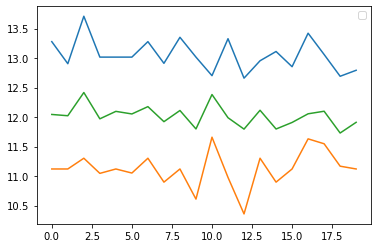

In [126]:
plt.plot(_99)
plt.plot(_1)
plt.plot(_mean)
plt.legend()

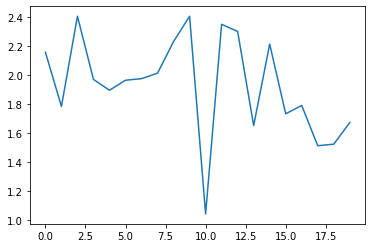

In [127]:
plt.plot(np.array(_99)-np.array(_1))

In [ ]:
# 각 직업별로 5년마다 구간 나눠서 평균 비교해보기

for job in train['occyp_type'].unique():
    temp = train[train['occyp_type']==job]
    temp = temp['income']
    print(f'{job}의 평균 수익', temp.mean())
    _mean.append(temp.mean())
    print(f'{job}의 상위99% 수익', np.percentile(temp,99))
    _99.append(np.percentile(temp,99))
    print(f'{job}의 하위99% 수익', np.percentile(temp,1))
    _1.append(np.percentile(temp,1))
    print()
    print()
    print("#"*30)

In [118]:
np.percentile(list(range(100)), 99)

98.01

# label encoding
- gender, car, reality, work_phone, phone, email, occyp_type, income_type, edu_type, family_size, house_type

In [12]:
from sklearn.preprocessing import OrdinalEncoder as OE
labels = ['gender', 'car', 'reality', 'work_phone', 'phone', 'email', 'occyp_type', 'income_type', 'edu_type', 'family_type', 'house_type']

In [13]:
train.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


In [14]:
from sklearn.preprocessing import OrdinalEncoder as OE
from sklearn.preprocessing import LabelEncoder as LE
labels = ['gender', 'car', 'reality', 'work_phone', 'phone', 'email', 'occyp_type', 'income_type', 'edu_type', 'family_type', 'house_type']
for label in labels:
    enc = LE()
    enc.fit(total[label])
    train[label] = enc.transform(train[label])
    test[label] = enc.transform(test[label])

In [ ]:
np.nan

In [89]:
import xgboost as xgb
rk_clf = xgb.XGBRFClassifier(random_state=1123)
sk_clf = xgb.XGBRFClassifier(random_state=1123)

In [75]:
X = train[['gender', 'car', 'reality', 'child_num', 'income_total',
       'income_type', 'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'work_phone', 'phone', 'email',
       'occyp_type', 'family_size', 'begin_month']]
y = train['credit']

In [80]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True,random_state=1123)

from sklearn.model_selection import KFold
rkf = KFold(n_splits=5, shuffle=True, random_state=1123)

In [77]:
from sklearn.model_selection import cross_val_score

In [81]:
%%time
score_rkf = cross_val_score(rk_clf, X, y, cv=rkf)

Wall time: 6.53 s


In [82]:
%%time
score_skf = cross_val_score(sk_clf, X, y, cv=skf)

Wall time: 5.99 s


In [85]:
score_rkf.mean()

0.690479204764919

In [86]:
score_skf.mean()

0.6904032832604262

In [87]:
test_X = test[['gender', 'car', 'reality', 'child_num', 'income_total',
       'income_type', 'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'work_phone', 'phone', 'email',
       'occyp_type', 'family_size', 'begin_month']]

In [90]:
sk_clf.fit(X, y, eval_metric='logloss')
rk_clf.fit(X,y, eval_metric='logloss')

pred_sk = sk_clf.predict(test_X)
pred_rk = rk_clf.predict(test_X)

In [105]:
ss_sk = pd.concat([ss['index'],pd.get_dummies(pd.Series(pred_sk).astype('int'))],axis=1)
ss_rk = pd.concat([ss['index'],pd.get_dummies(pd.Series(pred_rk).astype('int'))],axis=1)

In [107]:
ss_rk.to_csv('kfold_baseline.csv',index=False)
ss_sk.to_csv('skfold_baseline.csv',index=False)

In [104]:
ss['index']

0       26457
1       26458
2       26459
3       26460
4       26461
        ...  
9995    36452
9996    36453
9997    36454
9998    36455
9999    36456
Name: index, Length: 10000, dtype: int64